In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

 14%|█▍        | 8/58 [00:10<01:08,  1.37s/it]


KeyboardInterrupt: ignored

In [ ]:
vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
list(vgg.features)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [ ]:
import numpy as np
print(np.count_nonzero(f_all))

15032320


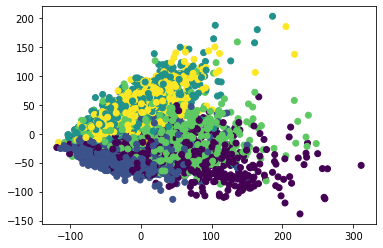

In [ ]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

**t-SNE**

---



In [ ]:
from sklearn.manifold import TSNE

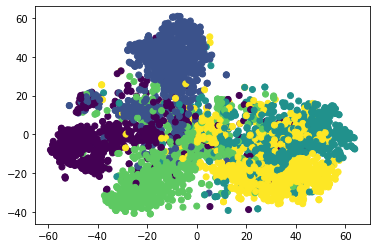

In [ ]:
dim_red = TSNE(n_components=2, learning_rate = 'auto',init = 'random').fit_transform(f_all)
plt.scatter(*dim_red.T, c=y_all)

**MLP CLASSIFIER**

---





In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:

              optimizer.zero_grad()
              outputs = self(X_)

              loss = criterion(outputs, y_)
              loss.backward()
              optimizer.step()

        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        X = torch.tensor(X_test, dtype=torch.float32, device='cuda')
        y = torch.tensor(y_test, dtype=torch.int64, device='cuda')

        criterion = nn.NLLLoss()
        dataset = TensorDataset(X, y)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

        total = 0 
        corr = 0 

        with torch.no_grad():
          for (X,y) in dataloader : 
            output = self.model(X)
            _,pred = torch.max(output,1)
            total += y.size(0)
            corr  += (pred==y).sum().item()

        accuracy = (corr/total)*100 
      
        return accuracy
        

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(f_all,y_all,test_size=0.2)

mlp = MLP(f_all.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)

100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


90.59945504087193

**AUTOENCODER**

---



In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:
X_em =Autoencoder(50).fit_transform(f_all)
X_em.shape

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


(3670, 50)

## MLP with Reduced Features 

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_em,y_all,test_size=0.2)

mlp = MLP(X_em.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)

100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


87.32970027247956

*AUTOENCODER WITH k-means*


---



In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.cluster import rand_score

km = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30, init='k-means++')
km.fit(f_all)

km_a = Autoencoder(50).fit_transform(f_all)
kmean_a = km.fit(km_a)
print("K-means Clustering- Rand Score: %.3f"% adjusted_rand_score(y_all, kmean_a.labels_))

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


K-means Clustering- Rand Score: 0.201


*AUTOENCODER WITH AGGLOMERATIVE CLUSTERING*

---



In [ ]:
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(km_a)
print("Agglomerative Clustering, Ward - Rand Score: %.3f"% adjusted_rand_score(y_all, ac_w.labels_))

Agglomerative Clustering, Ward - Rand Score: 0.176


In [ ]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311897 sha256=30b3ab341a7cc6f99e1d789b89fd9ab4d2616d96f91738df44d81440766f6765
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


*AUTOENCODER WITH HDBSCAN*

---



In [ ]:
import hdbscan
rand = []
mcs_rec=[]
ms_rec=[]
mcs = [5,15,30,60,100,200,500,1000,3000]
ms = [5,15,30,60,100,200,500]
for i in range(len(mcs)):
    for j in range(len(ms)):
        print('Testing for min_cluster_size and min_sample = ',mcs[i],'and',ms[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs[i],cluster_selection_epsilon=0.3,min_samples=ms[j],core_dist_n_jobs=-1).fit_predict(km_a)
        rand.append(adjusted_rand_score(y_all, hdbs))
        mcs_rec.append(mcs[i])
        ms_rec.append(ms[j])
        
print('Done testing')

Testing for min_cluster_size and min_sample =  5 and 5
Testing for min_cluster_size and min_sample =  5 and 15
Testing for min_cluster_size and min_sample =  5 and 30
Testing for min_cluster_size and min_sample =  5 and 60
Testing for min_cluster_size and min_sample =  5 and 100
Testing for min_cluster_size and min_sample =  5 and 200
Testing for min_cluster_size and min_sample =  5 and 500
Testing for min_cluster_size and min_sample =  15 and 5
Testing for min_cluster_size and min_sample =  15 and 15
Testing for min_cluster_size and min_sample =  15 and 30
Testing for min_cluster_size and min_sample =  15 and 60
Testing for min_cluster_size and min_sample =  15 and 100
Testing for min_cluster_size and min_sample =  15 and 200
Testing for min_cluster_size and min_sample =  15 and 500
Testing for min_cluster_size and min_sample =  30 and 5
Testing for min_cluster_size and min_sample =  30 and 15
Testing for min_cluster_size and min_sample =  30 and 30
Testing for min_cluster_size and mi

In [ ]:
best_mcs_hdb = mcs_rec[rand.index(max(rand))]
best_ms_hdb = ms_rec[rand.index(max(rand))]
print('Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN: ', best_mcs_hdb,'and',best_ms_hdb)
print('Rand Score:  %.3f' % max(rand))

Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN:  5 and 5
Rand Score:  0.013


**SVD with k-means**

---



In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import KMeans,  AgglomerativeClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.cluster import rand_score

km = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30, init='k-means++')
km.fit(f_all)

svd = TruncatedSVD(n_components=50, random_state=0)
svd_km = svd.fit_transform(f_all)
kmean_svd = km.fit(svd_km)
print("K-means Clustering- Rand Score: %.3f"% adjusted_rand_score(y_all, kmean_svd.labels_))

K-means Clustering- Rand Score: 0.192


**SVD with Agglomerative Clustering**

---



In [ ]:
ac_w = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(svd_km)
print("Agglomerative Clustering, Ward - Rand Score: %.3f"% adjusted_rand_score(y_all, ac_w.labels_))

Agglomerative Clustering, Ward - Rand Score: 0.216


**SVD with HDBSCAN**

---



In [ ]:
import hdbscan
rand = []
mcs_rec=[]
ms_rec=[]
mcs = [5,15,30,60,100,200,500,1000,3000]
ms = [5,15,30,60,100,200,500]
for i in range(len(mcs)):
    for j in range(len(ms)):
        print('Testing for min_cluster_size and min_sample = ',mcs[i],'and',ms[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs[i],cluster_selection_epsilon=0.3,min_samples=ms[j],core_dist_n_jobs=-1).fit_predict(svd_km)
        rand.append(adjusted_rand_score(y_all, hdbs))
        mcs_rec.append(mcs[i])
        ms_rec.append(ms[j])
        
print('Done testing')

Testing for min_cluster_size and min_sample =  5 and 5
Testing for min_cluster_size and min_sample =  5 and 15
Testing for min_cluster_size and min_sample =  5 and 30
Testing for min_cluster_size and min_sample =  5 and 60
Testing for min_cluster_size and min_sample =  5 and 100
Testing for min_cluster_size and min_sample =  5 and 200
Testing for min_cluster_size and min_sample =  5 and 500
Testing for min_cluster_size and min_sample =  15 and 5
Testing for min_cluster_size and min_sample =  15 and 15
Testing for min_cluster_size and min_sample =  15 and 30
Testing for min_cluster_size and min_sample =  15 and 60
Testing for min_cluster_size and min_sample =  15 and 100
Testing for min_cluster_size and min_sample =  15 and 200
Testing for min_cluster_size and min_sample =  15 and 500
Testing for min_cluster_size and min_sample =  30 and 5
Testing for min_cluster_size and min_sample =  30 and 15
Testing for min_cluster_size and min_sample =  30 and 30
Testing for min_cluster_size and mi

In [ ]:
best_mcs_hdb = mcs_rec[rand.index(max(rand))]
best_ms_hdb = ms_rec[rand.index(max(rand))]
print('Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN: ', best_mcs_hdb,'and',best_ms_hdb)
print('Rand Score:  %.3f' % max(rand))

Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN:  15 and 5
Rand Score:  0.010


In [ ]:
!pip install umap_learn

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 32.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=a3cd92117b47be41b685ac079fb7ccd228a3d71e9a87899bfb0984463c88c0e2
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=fce3fe121a110b75e354d8d0f7e4d210699d9cd53712f66e617c60bc48435c59
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


**UMAP with k-means**

---



In [ ]:
import umap.umap_ as umap

In [ ]:
Umap_cos = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(Umap_cos,y_all,test_size=0.2)

mlp = MLP(Umap_cos.shape[1])
mlp.train(X_train,y_train)
mlp.eval(X_test,y_test)

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


87.60217983651226

In [ ]:
km = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init=30, init='k-means++')
Umap_cos = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)
kmean_cos = km.fit(Umap_cos)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
print("K-means Clustering- Rand Score: %.3f"% adjusted_rand_score(y_all, kmean_cos.labels_))

K-means Clustering- Rand Score: 0.466


**UMAP with Agglomerative Clustering**

---



In [ ]:
Umap_cos = umap.UMAP(n_components=50, metric='cosine').fit_transform(f_all)
ac_w_umap = AgglomerativeClustering(n_clusters=20, linkage='ward').fit(Umap_cos)
print("Agglomerative Clustering- Rand Score: %.3f"% adjusted_rand_score(y_all, ac_w_umap.labels_))

Agglomerative Clustering- Rand Score: 0.300


**UMAP with HDBSCAN**

---



In [ ]:
rand = []
mcs_rec=[]
ms_rec=[]
mcs = [5,15,30,60,100,200,500,1000,3000]
ms = [5,15,30,60,100,200,500]
for i in range(len(mcs)):
    for j in range(len(ms)):
        print('Testing for min_cluster_size and min_sample = ',mcs[i],'and',ms[j])
        hdbs = hdbscan.HDBSCAN(min_cluster_size=mcs[i],cluster_selection_epsilon=0.3,min_samples=ms[j],core_dist_n_jobs=-1).fit_predict(Umap_cos)
        rand.append(adjusted_rand_score(y_all, hdbs))
        mcs_rec.append(mcs[i])
        ms_rec.append(ms[j])
        
print('Done testing')

Testing for min_cluster_size and min_sample =  5 and 5
Testing for min_cluster_size and min_sample =  5 and 15
Testing for min_cluster_size and min_sample =  5 and 30
Testing for min_cluster_size and min_sample =  5 and 60
Testing for min_cluster_size and min_sample =  5 and 100
Testing for min_cluster_size and min_sample =  5 and 200
Testing for min_cluster_size and min_sample =  5 and 500
Testing for min_cluster_size and min_sample =  15 and 5
Testing for min_cluster_size and min_sample =  15 and 15
Testing for min_cluster_size and min_sample =  15 and 30
Testing for min_cluster_size and min_sample =  15 and 60
Testing for min_cluster_size and min_sample =  15 and 100
Testing for min_cluster_size and min_sample =  15 and 200
Testing for min_cluster_size and min_sample =  15 and 500
Testing for min_cluster_size and min_sample =  30 and 5
Testing for min_cluster_size and min_sample =  30 and 15
Testing for min_cluster_size and min_sample =  30 and 30
Testing for min_cluster_size and mi

In [ ]:
best_mcs_hdb = mcs_rec[rand.index(max(rand))]
best_ms_hdb = ms_rec[rand.index(max(rand))]
print('Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN: ', best_mcs_hdb,'and',best_ms_hdb)
print('Rand Score:  %.3f' % max(rand))

Best value of min cluster size and minimum number of samples hyperparameters for HDBSCAN:  5 and 5
Rand Score:  0.095
